In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import plot_model
from classes import *
from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
dataset_high_res = tf.keras.utils.image_dataset_from_directory(directory='C:\\Users\\gupta\\Downloads\\archive\\img_align_celeba\\img_align_celeba',
                                                        labels=None,
                                                        label_mode=None,
                                                        batch_size=1,
                                                        image_size=(128,128),
                                                        shuffle=False,
                                                        interpolation='bicubic'
)
resize = tf.keras.layers.Resizing(32,32,interpolation='bicubic')
dataset_low_res = []
for i in dataset_high_res:
    dataset_low_res.append(resize(i))
dataset_low_res = list(dataset_low_res)
dataset_high_res = list(dataset_high_res)
dataset_high_res = tf.data.Dataset.from_tensor_slices(dataset_high_res)
dataset_low_res = tf.data.Dataset.from_tensor_slices(dataset_low_res)
dataset_comb = tf.data.Dataset.zip(datasets=(dataset_low_res,dataset_high_res))
dataset_comb_tuple = tuple(dataset_comb)

Found 2560 files belonging to 1 classes.


In [3]:
# hr = tuple(dataset_comb)[0][1]
# gen = Generator()
# dis = Discriminator()
# hr_dis = dis(hr)
# hr_dis

In [4]:
generator = Generator()
discriminator = Discriminator()
# Initialise both to instantiate weights of the models
generator.build(input_shape=(1,32,32,3))
discriminator.build(input_shape=(1,128,128,3))

In [5]:
# optimiser for discriminator
d_optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
# optimiser for generator
g_optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
epochs = 5
vgg_loss = VGGloss()
for epoch in range(epochs):
    for idx,(low_res,high_res) in enumerate(dataset_comb.take(1000)):
        # The supposed high resolution image outputed by the generator
        super_res = generator(low_res)


        discriminator.trainable = True
        generator.trainable = False

        # Training the Discriminator
        with tf.GradientTape() as tape1:
            # Get the opinion of the discriminator on what it thinks these images are
            sr_dis = discriminator(super_res)
            hr_dis = discriminator(high_res)

            # Calculate the loss between discriminator's opinion of the images and the ground truth
            real_score = tf.keras.losses.binary_crossentropy(tf.ones(shape=tf.shape(hr_dis)), hr_dis)
            fake_score = tf.keras.losses.binary_crossentropy(tf.zeros(shape=tf.shape(sr_dis)), sr_dis)

            # Add the loss for both super res and high res
            discriminator_loss = real_score + fake_score
        discriminator_gradients = tape1.gradient(discriminator_loss,discriminator.trainable_weights)
        d_optim.apply_gradients(zip(discriminator_gradients,discriminator.trainable_weights))

        discriminator.trainable = False
        generator.trainable = True

        with tf.GradientTape() as tape2:
            # Get the super res image again to let the tape2 record it
            sr = generator(low_res)
            # Calculate the content loss using the vgg model
            content_loss = vgg_loss(sr,high_res)
            # get the opinion of discriminator on the generated image by the generator
            sr_dis = discriminator(sr)
            # Calculate the loss on if the generator was able to fool the discriminator or not
            adverserial_loss = tf.keras.losses.binary_crossentropy(tf.ones(shape=tf.shape(sr_dis)),sr_dis)
            # add the content and adverserial loss
            generator_loss = content_loss + 1e-3*adverserial_loss
        generator_gradients = tape2.gradient(generator_loss,generator.trainable_weights)
        g_optim.apply_gradients(zip(generator_gradients,generator.trainable_weights))
        if idx%100==0:
            print(idx,end=" ")
    print(epoch)

0 100 200 300 400 500 600 700 800 900 0
0 100 200 300 400 500 600 700 800 900 1
0 100 200 300 400 500 600 700 800 900 2
0 100 200 300 400 500 600 700 800 900 3
0 100 200 300 400 500 600 700 800 900 4


In [28]:
img = tf.keras.utils.load_img('Deadpool_2_Japan_Premiere_Red_Carpet_Ryan_Reynolds_(cropped).jpg')
img = tf.keras.utils.img_to_array(img)
high_res = tf.keras.layers.Resizing(128,128,interpolation='bicubic')(img)
low_res = tf.keras.layers.Resizing(32,32,interpolation='bicubic')(img)
low_res = tf.expand_dims(low_res,axis=0)
super_res = generator(low_res)
# fig, (ax1,ax2,ax3) = plt.subplots(1,3)
# ax1.imshow(tf.squeeze(low_res)/255)
# ax2.imshow(tf.squeeze(super_res)/255)
# ax3.imshow(tf.squeeze(high_res)/255)
super_res = super_res.numpy()
super_res[:, :, 0] = super_res[:, :, 0] + 
super_res[:, :, 1] = super_res[:, :, 1] + 
super_res[:, :, 2] = super_res[:, :, 2] + 
tf.reduce_min(super_res)

<tf.Tensor: shape=(), dtype=float32, numpy=-38.087475>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


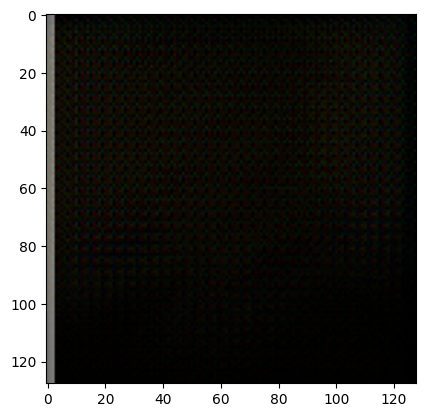

In [21]:
plt.imshow(tf.squeeze(super_res)/255)